## Testing of the TotalSegmentator

In [1]:
#Imports
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator
import os
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from ipywidgets import interact, HBox, VBox, widgets
import cv2
from scipy.ndimage import binary_fill_holes, label, center_of_mass

### The segmentation using totalsegmentator

In [2]:
labels = None
with open("Labels.txt", 'r') as file:
    labels = [line.rstrip() for line in file]
print(labels)

['vertebrae_C1', 'vertebrae_C2', 'vertebrae_C3', 'vertebrae_C4', 'vertebrae_C5', 'vertebrae_C6', 'vertebrae_C7', 'vertebrae_T1', 'vertebrae_T2', 'vertebrae_T3', 'vertebrae_T4', 'vertebrae_T5', 'vertebrae_T6', 'vertebrae_T7', 'vertebrae_T8', 'vertebrae_T9', 'vertebrae_T10', 'vertebrae_T11', 'vertebrae_T12', 'vertebrae_L1', 'vertebrae_L2', 'vertebrae_L3', 'vertebrae_L4', 'vertebrae_L5', 'vertebrae_S1']


In [13]:
dir = os.getcwd()
Segmentation_file_path = dir + "/Data/s0011/Segmentation_output.nii.gz"
if not os.path.exists(Segmentation_file_path):
    with open(Segmentation_file_path, 'w') as fp:
      pass
print(os.path.exists(Segmentation_file_path))
input_file_path = dir + "/Data/s0011/ct.nii.gz"
print(os.path.exists(input_file_path))


input_img = nib.load(input_file_path)
Segmentation_output = totalsegmentator(input_img, roi_subset=labels)
nib.save(Segmentation_output, Segmentation_file_path)
del Segmentation_output, input_img

100%|██████████| 4/4 [00:53<00:00, 13.27s/it]


# Slice rendering of segmentation
which is easier to use

In [3]:
def crop_image(out_im):
    non_zero_slices = [i for i in range(out_im.shape[0]) if np.any(out_im[i, :, :])]
    sagital_start = non_zero_slices[0] #Used for image reconstruction
    filtered = out_im[non_zero_slices, :, :]
    non_zero_slices = [i for i in range(filtered.shape[1]) if np.any(filtered[:, i, :])]
    frontal_start = non_zero_slices[0] #Used for image reconstruction
    filtered = filtered[:, non_zero_slices, :]
    non_zero_slices = [i for i in range(filtered.shape[2]) if np.any(filtered[:, :, i])]
    transversal_start = non_zero_slices[0] #Used for image reconstruction
    filtered = filtered[:, :, non_zero_slices]


    return filtered, sagital_start, frontal_start, transversal_start

In [4]:
def read_data(path = "/Data/s0011/Segmentation_output.nii.gz"):
    dir = os.getcwd()
    if os.path.exists(dir + path):
        output_img_new = nib.load(dir + path)
    else:
        print("No file found")

    # Convert to NumPy array
    output_img_data = np.array(output_img_new.dataobj)
    return output_img_new, output_img_data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import SimpleITK as sitk

#Resets the matplotlib, since totalSegmentator messes with the output
plt.close('all')
plt.switch_backend('module://ipykernel.pylab.backend_inline')

output_img_nifti, output_img_data = read_data()

filtered_data,_,_,_ = crop_image(output_img_data)

print(f"Original number of slices: {output_img_data.shape[0]}")
print(f"Number of slices after filtering: {filtered_data.shape[0]}")

# Define a function to plot sagittal slices
def plot_sagittal(slice_index):
    plt.figure(figsize=(8, 8))

    # Sagittal slice (fixing the first axis, after flipping)
    plt.imshow(filtered_data[slice_index, :, :], cmap='gray')
    plt.title(f"Sagittal Slice {slice_index}")
    plt.axis('off')

    plt.show()
    plt.close()  # Close the figure to avoid warning and memory issues

# Create an interactive slider for sagittal slices
interact(plot_sagittal, slice_index=(0, filtered_data.shape[0] - 1))


Original number of slices: 311
Number of slices after filtering: 59


interactive(children=(IntSlider(value=29, description='slice_index', max=58), Output()), _dom_classes=('widget…

<function __main__.plot_sagittal(slice_index)>

# Vertebra body extraction

In [125]:

def plot_segmentation(vis_arr, value=-1):

    #There might be some other way to define the functions outside of plot_segmentation.
    #But for now I do not care and this works.
    def plot_sagittal(slice_index):
        plt.figure(figsize=(8, 8))

        # Sagittal slice (fixing the first axis, after flipping)
        plt.imshow(vis_arr[slice_index, :, :], cmap='gray')
        plt.title(f"Area of Slice {count_per_sagital_slice[slice_index]}")
        plt.axis('off')

        plt.show()
        plt.close()  # Close the figure to avoid warning and memory issues

    def plot_frontal(slice_index):
        plt.figure(figsize=(8, 8))

        # Sagittal slice (fixing the first axis, after flipping)
        plt.imshow(vis_arr[:, slice_index, :], cmap='gray')
        plt.title(f"Area of Slice {count_per_frontal_slice[slice_index]}")
        plt.axis('off')

        plt.show()
        plt.close()  # Close the figure to avoid warning and memory issues

    def plot_transversal(slice_index):
        plt.figure(figsize=(8, 8))

        # Sagittal slice (fixing the first axis, after flipping)
        plt.imshow(vis_arr[:, :, slice_index], cmap='gray')
        plt.title(f"Area of Slice {count_per_transversal_slice[slice_index]}")
        plt.axis('off')

        plt.show()
        plt.close()  # Close the figure to avoid warning and memory issues


    #Get the area in each slice
    if value != -1:
        count_per_sagital_slice = np.sum(vis_arr == value, axis=(1, 2))
        count_per_frontal_slice = np.sum(vis_arr == value, axis=(0, 2))
        count_per_transversal_slice = np.sum(vis_arr == value, axis=(0, 1))
    else:
        values = np.unique(vis_arr)
        print(values)
        values = values[1:]
        print(values)
        print(vis_arr.shape)
        count_per_sagital_slice_list = {}
        count_per_frontal_slice_list = {}
        count_per_transversal_slice_list = {}
        for val in values:
            count_per_sagital_slice_list[val] = np.sum(vis_arr == values[val], axis=(1, 2))
            count_per_frontal_slice_list[val] = np.sum(vis_arr == values[val], axis=(0, 2))
            count_per_transversal_slice_list[val] = np.sum(vis_arr == values[val], axis=(0, 1))
        count_per_sagital_slice = np.sum(list(count_per_sagital_slice_list.values()), axis=0)
        count_per_frontal_slice = np.sum(list(count_per_frontal_slice_list.values()), axis=0)
        count_per_transversal_slice = np.sum(list(count_per_transversal_slice_list.values()), axis=0)



    #Find the maximum point for alls lices
    max_sag = np.argmax(count_per_sagital_slice)
    max_front = np.argmax(count_per_frontal_slice)
    max_trans = np.argmax(count_per_transversal_slice)

    # Create interactive sliders
    sagittal_slider = widgets.IntSlider(min=0, max=vis_arr.shape[0] - 1, value=max_sag, description="Sagittal")
    frontal_slider = widgets.IntSlider(min=0, max=vis_arr.shape[1] - 1, value=max_front, description="Frontal")
    transversal_slider = widgets.IntSlider(min=0, max=vis_arr.shape[2] - 1, value=max_trans, description="Transversal")

    # Create interactive plots
    sagittal_plot = widgets.interactive_output(plot_sagittal, {'slice_index': sagittal_slider})
    frontal_plot = widgets.interactive_output(plot_frontal, {'slice_index': frontal_slider})
    transversal_plot = widgets.interactive_output(plot_transversal, {'slice_index': transversal_slider})

    # Arrange widgets in a horizontal box
    ui = HBox([
        VBox([sagittal_slider, sagittal_plot]),
        VBox([frontal_slider, frontal_plot]),
        VBox([transversal_slider, transversal_plot])
    ])

    display(ui)
    

In [159]:
from scipy.interpolate import UnivariateSpline

def refine_hole_location(intensity_profile):
    """
    Use cubic spline interpolation to smooth out the hole detection
    and find a more centered transversal slice.
    """
    x = np.arange(len(intensity_profile))  # Slice indices
    spline = UnivariateSpline(x, intensity_profile, k=3, s=1)  # Smooth spline fit
    refined_idx = np.argmax(spline(x))  # Find the best refined peak
    return int(refined_idx)


def find_holes(binary_image_arg, start_index, axis=2, target_holes=1, invers=False):
    """Find holes in the given axis and return hole centers."""
    for slice_index in range(int(binary_image_arg.shape[axis] / 2)):
        for i in [0, 2, 1]:
            index = int(start_index + slice_index * ((-1) ** i))
            binary_image_slice = binary_image_arg.take(index, axis=axis)
            
            if invers:
                holes = binary_fill_holes(binary_image_slice) & ~binary_image_slice
            else:
                holes = binary_fill_holes(binary_image_slice) & binary_image_slice

            labeled_holes, num_holes = label(holes)

            if num_holes >= target_holes:
                print(f"Slice start: {start_index}, slice index: {slice_index}, direction: {(-1) ** i}")
                return holes, labeled_holes, index, center_of_mass(holes, labeled_holes, range(1, num_holes + 1))

    print(f"There were too few vertebrae for this label in the {'transversal' if axis == 2 else 'frontal'} slice")
    return None, None, None, None

def hole_find(binary_image_arg, plot=False):
    # Find the slice with the most foreground pixels
    #start_index = np.argmax(np.sum(binary_image_arg == 1, axis=(0, 1)))
    #start_index = int(binary_image_arg.shape[2]/2)
    intensity_profile = np.sum(binary_image_arg, axis=(1, 2))
    start_index = refine_hole_location(intensity_profile)

    # Find the transverse holes
    holes, labeled_holes, transversal_index, hole_centers = find_holes(binary_image_arg, start_index, axis=2, target_holes=1, invers=True)
    if holes is None:
        return None, None
    hole_centers = [(round(x), round(y)) for x, y in hole_centers] #Round down the center points to ints

    # Find the frontal holes using the first hole's center as a starting point
    start_index = hole_centers[0][1]
    holes_frontal, labeled_holes_frontal, frontal_index, hole_centers_frontal = find_holes(binary_image_arg, start_index, axis=1, target_holes=2, invers=False)
    if holes_frontal is None:
        return None, None
    hole_centers_frontal = [(round(x), round(y)) for x, y in hole_centers_frontal]

    if plot:
        # Plot transversal holes
        plt.imshow(holes, cmap='gray')
        plt.title("Binary Image with Transversal Holes")
        for y, x in hole_centers:
            plt.plot(x, y, 'ro', markersize=6)
        plt.show()

        print(f"Number of holes found: {len(hole_centers)}")
        print(f"Hole centers: {hole_centers}")

        # Plot frontal holes
        plt.imshow(holes_frontal, cmap='gray')
        plt.title("Binary Image with Frontal Holes")
        for y, x in hole_centers_frontal:
            plt.plot(x, y, 'ro', markersize=6)
        plt.show()

        print(f"Number of holes found: {len(hole_centers_frontal)}")
        print(f"Hole centers: {hole_centers_frontal}")
    
    #Format return
    return_holes = []
    return_holes_frontal = []
    for hole in hole_centers:
        return_holes.append([hole[0], hole[1], transversal_index])
    for hole in hole_centers_frontal:
        return_holes_frontal.append([hole[0], frontal_index, hole[1]])

    return return_holes,return_holes_frontal


In [128]:
def cut_body(new_arr, value, plot=False):
    #Crop the image for the vertebra
    temp, sagital_start, frontal_start, transversal_start = crop_image(new_arr)

    # Example binary image (object with holes)
    binary_image = (temp == value).astype(np.uint8) * 1

    #For frontal they are organised (Sagital slice, Transversal)
    #For transversal they are organised (Sagital, Frontal)
    transversal_holes,_ = hole_find(binary_image, plot)
    if transversal_holes == None:
        return temp, sagital_start, frontal_start, transversal_start 

    temp[:,0:int(np.floor(transversal_holes[0][1])),:] = 0
    return temp, sagital_start, frontal_start, transversal_start

def restore_array(original_array, cut_array, sagital_start, frontal_start, transversal_start, value):
    return_array = np.copy(original_array)
    sagital_end = sagital_start + cut_array.shape[0]
    frontal_end = frontal_start + cut_array.shape[1]
    transversal_end = transversal_start + cut_array.shape[2]

    mask = (return_array[sagital_start:sagital_end, frontal_start:frontal_end, transversal_start:transversal_end] == value)
    return_array[sagital_start:sagital_end, frontal_start:frontal_end, transversal_start:transversal_end][mask] = cut_array[mask]

    return return_array


In [147]:
import numpy as np

def fit_plane(points):
    """ Fit a plane to three points using least squares. """
    points = np.array(points)
    centroid = points.mean(axis=0)  # Compute centroid of the three points
    _, _, vh = np.linalg.svd(points - centroid)
    normal = vh[2]  # The last row of Vh is the normal to the best-fit plane
    if normal[1] < 0:
        normal = normal * -1
    return normal, centroid

def point_to_plane_dist(point, normal, centroid):
    """ Compute the signed distance from a point to the plane. """
    return np.dot(point - centroid, normal)

def remove_back_part(volume, center, conn1, conn2):
    """ 
    Cut the vertebra along the plane defined by the center hole and connection points.
    """
    # Fit the cutting plane
    normal, centroid = fit_plane([center, conn1, conn2])
    print(normal)
    print(centroid)

    # Generate voxel coordinates
    coords = np.indices(volume.shape).reshape(3, -1).T  # Shape: (N, 3) for all voxels
    distances = np.dot(coords - centroid, normal)  # Compute distances of all points to plane

    # Mask for voxels behind the plane
    mask = distances < 0  # True for voxels to be removed

    # Apply cut only where the vertebra exists (where value == 30)
    volume[np.reshape(mask, volume.shape)] = 0  # Set cut voxels to 0

    return volume


Slice start: 21, slice index: 1, direction: 1
Slice start: 35, slice index: 10, direction: -1


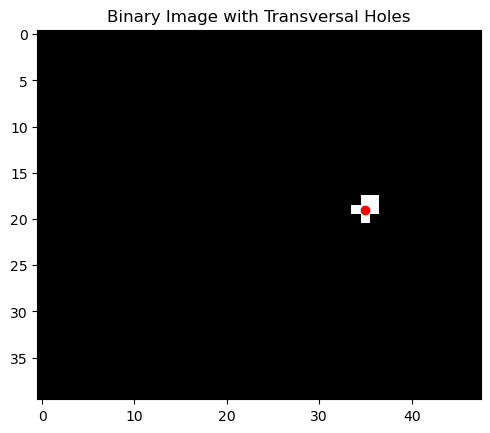

Number of holes found: 1
Hole centers: [(19, 35)]


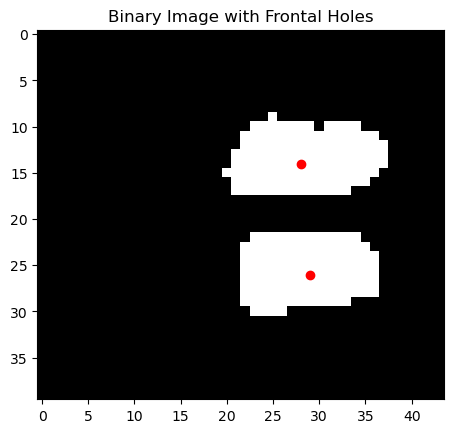

Number of holes found: 2
Hole centers: [(14, 28), (26, 29)]
[[19, 35, 22]]
[[14, 25, 28], [26, 25, 29]]
[-0.06996429  0.53872505  0.83957151]
[19.66666667 28.33333333 26.33333333]
(40, 48, 44)


In [160]:
#Testing cell
output_img_info, output_img_data = read_data()
value = 36
array = (output_img_data == value).astype(np.uint8) * value
temp, sagital_start, frontal_start, transversal_start = crop_image(array)

# Example binary image (object with holes)
binary_image = (temp == value).astype(np.uint8) * 1

#For frontal they are organised (Sagital slice, Transversal)
#For transversal they are organised (Sagital, Frontal)
transversal_holes,frontal_holes = hole_find(binary_image, True)
print(transversal_holes)
print(frontal_holes)

modified_vertebra = remove_back_part(binary_image, transversal_holes[0], frontal_holes[0], frontal_holes[1])
print(modified_vertebra.shape)
plot_segmentation(modified_vertebra, value=1)

In [ ]:
#Testing cell
output_img_nifti, output_img_data = read_data()
values = np.unique(output_img_data)
values = values[1:]
for value in values:
    print(value)
    array = (output_img_data == value).astype(np.uint8) * value
    temp, sagital_start, frontal_start, transversal_start = crop_image(array)
    print(temp.shape)

    # Example binary image (object with holes)
    binary_image = (temp == value).astype(np.uint8) * 1
    print(binary_image.shape)

    #For frontal they are organised (Sagital slice, Transversal)
    #For transversal they are organised (Sagital, Frontal)
    transversal_holes,frontal_holes = hole_find(binary_image, False)
    print(transversal_holes)
    print(frontal_holes)

    if transversal_holes == None:
        print("Broken")
        output_img_data = restore_array(output_img_data, temp, sagital_start, frontal_start, transversal_start, value)
        break


    temp = remove_back_part(temp, transversal_holes[0], frontal_holes[0], frontal_holes[1])
    output_img_data = restore_array(output_img_data, temp, sagital_start, frontal_start, transversal_start, value)
plot_segmentation(output_img_data, value=30)

In [161]:
#Test cell
output_img_info, output_img_data = read_data()
value = 37
array = (output_img_data == value).astype(np.uint8) * value
tmp, sagital_start, frontal_start, transversal_start = crop_image(array)
plot_segmentation(tmp, value)

Slice start: 22, slice index: 0, direction: 1
Slice start: 35, slice index: 10, direction: -1


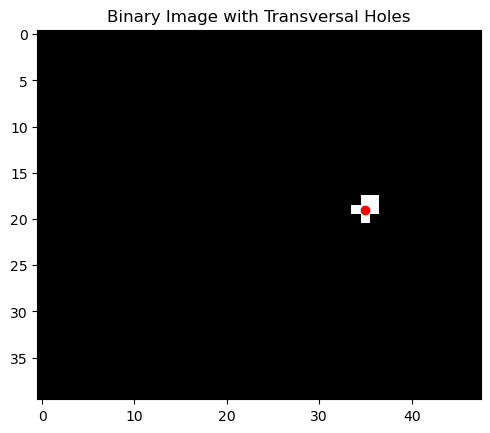

Number of holes found: 1
Hole centers: [(19, 35)]


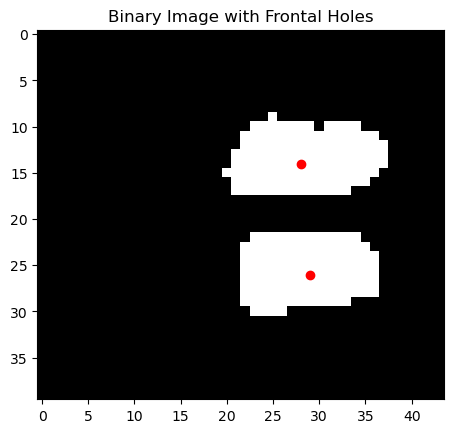

Number of holes found: 2
Hole centers: [(14, 28), (26, 29)]


In [155]:
#Real working cell
output_img_info, output_img_data = read_data()
value = 36
array = (output_img_data == value).astype(np.uint8) * value
tmp, sagital_start, frontal_start, transversal_start = cut_body(array, value, plot=True)
plot_segmentation(tmp, value)
tmp2 = restore_array(output_img_data, tmp, sagital_start, frontal_start, transversal_start, value)
plot_segmentation(tmp2, value)

In [ ]:
output_img_nifti, output_img_data = read_data()
values = np.unique(output_img_data)
values = values[1:]
for value in values:
    print(value)
    array = (output_img_data == value).astype(np.uint8) * value
    tmp, sagital_start, frontal_start, transversal_start = cut_body(array, value, plot=True)
    output_img_data = restore_array(output_img_data, tmp, sagital_start, frontal_start, transversal_start, value)
plot_segmentation(output_img_data, value=30)

In [48]:
data = read_data()
value=30
array = (output_img_data == value).astype(np.uint8) * value
#array,_,_,_ = crop_image(array)
plot_segmentation(array, value)

### Save results

In [71]:
print(output_img_data.shape)
nii_img = nib.Nifti1Image(output_img_data, affine=np.eye(4))  # Identity matrix as default affine

# Save the NIfTI file
nib.save(nii_img, r'Data\\s0011\\Cropped_segmentation.nii')

(311, 311, 431)
